In [12]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, IBMQ
from qiskit import providers
from qiskit.providers.aer import AerSimulator
from qiskit.tools.monitor import job_monitor

import matplotlib as mpl
import random
import numpy as np
import pandas as pd
import copy


In [13]:
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub="ibm-q")

# Quantum Circuit Class

In [14]:
##
##  A class to wrap the qiskit QuantumCircuit
##    It can allocate registers in sequence, which is very useful
##
class QC:
    def __init__(self, genBarriers=True):
        self.regNum = 0
        self.genBarriers = genBarriers
        self.qcx = QuantumCircuit()
        self.falseBit = self.addReg('false')
        self.trueBit  = self.addReg('true')
        self.qcx.x(self.trueBit)
        
    def getQuantumCircuit(self):
        return self.qcx

    def get_name(self, prefix=""):
        name = prefix+"_"+str(self.regNum)
        self.regNum+=1
        return name        
    
    def addReg(self, prefix="t"):
        name = self.get_name(prefix)
        result = QuantumRegister(1, name)
        self.qcx.add_register(result)
        return result

##
##  Measure the specified qubit onto a new classical bit
##     returns:  the classical register
##
    def mbit(self, qbit):
        result = ClassicalRegister(1, "m"+qbit.name)
        self.qcx.add_register(result)
        self.qcx.measure(qbit, result)
        return result

##
##  Put in barriers, or not, as dicitated by self.genBarriers
##
    def barrier(self):
        if self.genBarriers:
            self.qcx.barrier()
##
##  Emulate locally
##
    def em(self, shots=512):
        em = Aer.get_backend('aer_simulator_matrix_product_state')
        job = execute(self.qcx, em, shots=shots)
        hist = job.result().get_counts()
        return hist
    
    def bem(self, shots=512, method='simulator_mps'):
        provider = IBMQ.get_provider(hub='ibm-q')
        real_device = provider.get_backend("simulator_mps")
        print('Status:')
        print('  Operational: ', real_device.status().operational)
        print('  Pending jobs:', real_device.status().pending_jobs)
        print('  Status message:', real_device.status().status_msg)
        job = execute(self.qcx, real_device, shots=shots)
        job_monitor(job, interval=2)
        res = job.result()
        return res.get_counts()
    
    def genOutput(self, reg, name):
        reg = reg if reg else self.addReg(name)
        return reg
    
    def qand(self, bit1, bit2, output=None):
        output = self.genOutput(output, "and")
        self.barrier()
        self.qcx.ccx(bit1, bit2, output)
        self.barrier()
        return output


    def qor(self, bit1, bit2, output=None):
        output = self.genOutput(output, "or")
        self.barrier()
        self.qcx.cx(bit1, output)
        self.qcx.cx(bit2, output)
        self.qcx.ccx(bit1, bit2, output)
        self.barrier()
        return output
    
    def qxor(self, bit1, bit2, output=None):
        output = self.genOutput(output, "xor")
        self.barrier()
        self.qcx.cx(bit1, output)
        self.qcx.cx(bit2, output)
        self.barrier()
        return output
##
##  While we don't need this method for completeness,
##     it can perform a 3-way xor without generating a
##     temporary, intermediate result, thus saving qubits
##
    def qxor3(self, bit1, bit2, bit3, name="xor3", output=None):
        output = self.genOutput(output, name)
        self.barrier()
        self.qcx.cx(bit1, output)
        self.qcx.cx(bit2, output)
        self.qcx.cx(bit3, output)
        self.barrier()
        return output

    def qnot(self, bit, output=None):
        output = self.genOutput(output, "not")
        self.barrier()
        self.qcx.x(bit)
        self.qcx.cx(bit, output)
        self.qcx.x(bit)
        self.barrier()
        return output

    def qnand(self, bit1, bit2, output=None):
        output = self.genOutput(output, "nand")
        self.barrier()
        self.qcx.ccx(bit1, bit2, output)
        self.qcx.x(output)
        self.barrier()
        return output
    
    def same(self, bit1, bit2, output=None):
        output = self.genOutput(output, "same")
        self.barrier()
        self.qcx.cx(bit1, output)
        self.qcx.cx(bit2, output)
        self.barrier()
        return output
        

###
### A more qulever carry computation, requiring no intermediate results
###   If exactly two bits are true, the output is flipped once, making it True
##    If all three are true, the output flips 3 times, making it True
##    If exactly one bit is true, no flipping occurs
##
    def quarry(self, bit1, bit2, bit3, output=None):
        output = self.genOutput(output, "quarry")
        self.barrier()
        self.qcx.ccx(bit1, bit2, output)
        self.qcx.ccx(bit2, bit3, output)
        self.qcx.ccx(bit1, bit3, output)
        self.barrier()
        return output
    
    
    def draw(self, output='mpl'):
        return self.qcx.draw(output=output)

# Quantum Arithmetic Class

In [15]:
##
##  Create integers and sums for the supplied quantum circuit
##    Throughout, a value is represented as a list of quantum registers,
##      least-significant-bit-first
##
class QVarArith:
    def __init__(self, qc):
        self.qc = qc
        self.ONE   = self.qint(1, "one")

    def numBits(self, val):
        if val == 0:
            return 1
        ans = int(np.log2(val))+1
        return ans
##
##  Create the supplied value on the quantum circuit
##
    def qint(self, val, name=None, width=None):
        if not width:
            width = self.numBits(val)
        if not name:
            name = "qi("+str(val)+")"
        bitVal = []
        a = 1
        for i in range(width):
            t = self.qc.addReg(name)
            if val & a:
                self.qc.getQuantumCircuit().x(t)
            a = a << 1
            bitVal.append(t)
        return bitVal
    
#this is so our shadow registers for qvararith can have defined length w/out defined value
    def qtemp(self,val,name=None):
        width = self.numBits(val)
        if not name:
            name = "qtempshad("+str(val)+")"
        bitVal = []
        for i in range(width):
            t = self.qc.addReg(name)
            bitVal.append(t)
        return bitVal
##
##  cin -- carry in
##  ba - one bit of input
##  bb -- other bit of input
##  returns the sum and carry bits
##
    def onebit(self, cin, ba, bb):
        ##
        ##  Using a 3-way :-) to save on qubits
        ##
        s = self.qc.qxor3(cin, ba, bb, name="add")
        cout = self.qc.quarry(cin, ba, bb)
        return s, cout
    
    def onebitshort(self, cin, ba, output=None):
        output = self.qc.genOutput(output, "quarry")
        s = self.qc.qxor(cin, ba)
        
        self.qc.getQuantumCircuit().ccx(cin, ba, output)
        return s, output
##
##  add the two inputs, returning the result
##
    def add(self, val1, val2, width = 10):
        if len(val1) > len(val2):
            return self.add(val2, val1, width)
        ans   = []
        carry = self.qc.falseBit
        for i in range(len(val2)):
            if i<len(val1):
                s, carry = self.onebit(carry, val1[i], val2[i])
                ans.append(s)
            else:
                ##only need to add val2 and the carry at this point
                s, carry = self.onebitshort(carry, val2[i])
                ans.append(s)
        while len(ans) < width:
            ans.append(carry)
            carry = self.qc.addReg('pad')
        return ans
    
    def onescomp(self, val):
        self.qc.barrier()
        width = len(val)
        ans = []
        for i in range(width):
            ans.append(self.qc.qnot(val[i]))
        self.qc.barrier()
        return ans
    
    def compBits(self, val1, val2):
        self.qc.barrier()
        width = len(val1)
        while len(val1) < len(val2):
            val1.append(self.qc.falseBit)
        while len(val2) < len(val1):
            val2.append(self.qc.falseBit)
        ans = []
        for i in range(width):
            ans.append(self.qc.same(val1[i],val2[i]))
        self.qc.barrier()
        return ans
    
    def allZeros(self,val,output=None):
        self.qc.barrier()
        if not output:
            output = self.qc.genOutput(output, "allZero")
        for i in range(len(val)):
            self.qc.getQuantumCircuit().x(val[i])
        self.qc.getQuantumCircuit().mcx(val,output)
        for i in range(len(val)):
            self.qc.getQuantumCircuit().x(val[i])
        self.qc.barrier()
        return output

    def qompare(self, val1, val2):
        return self.allZeros(self.compBits(val1,val2))
                
    def neg(self, val): 
        return self.add(self.onescomp(val), self.ONE, len(val))
    
    def measure(self, val):
        width = len(val)
        result = []
        for i in range(width):
            b = self.qc.mbit(val[i])
            result.append(b)
        return result
    
    

# Subset Sum Class

In [16]:
class QSubsetSum:
    
    def __init__(self, values, target, qc=None):
        if not qc:
            self.qc = QC()
        else:
            self.qc = qc
        self.values = values
        self.target = target

    
    def run(self,  test=False, sorted = True, partial = True, variable=True, width=None):
        if sorted:
            self.values.sort()
        if not width: #this allows us to do operations on a fixed bit length
            widthOfSum = int(np.log2(sum(self.values)))+1
        else:
            widthOfSum = width
        self.qi = QVarArith(self.qc)
        if variable:
            qintwidth = None
        else:
            qintwidth = widthOfSum
        
        self.x = []
        for i in range(len(self.values)): #creates x register
            r = self.qc.addReg(prefix = "x")
            self.x.append(r)
            ##
            ##  call for the superposition of all
            ##   possible x values
            ##
            self.qc.getQuantumCircuit().h(r)

        ##
        ##  sorted and unsorted versions
        ##
        ##  Create the running sum of integers in my (unsorted) set
        ##  ans maintains the running sum, and is returned at thend
        ##  By "sum" we mean that each integer in the set is either added
        ##    into the sum, or not, depending on the x control register
        ##  
        ##  ans starts out as a new register, all 0
        ##
        ans = self.qi.qint(0, name = "sum")
        
        if partial:
            totsum = 0
        else:
            totsum = int(sum(self.values))
        for i, s in enumerate(self.values): #stores integers as quantum registers
            r = self.qi.qint(s, width=qintwidth)
            ctrl = self.x[i]
            if partial:
                totsum += self.values[i]
            shadow = self.qi.qtemp(s, name = "shd")
            for a in range(len(shadow)):
                self.qc.getQuantumCircuit().ccx(ctrl, r[a], shadow[a]) #
            if width==None:
                ans = self.qi.add(ans, shadow, self.qi.numBits(totsum))
            else:
                ans = self.qi.add(ans, shadow, qintwidth)
        if width==None:
            targ = self.qi.qint(self.target, name = "target", width=len(ans))
        else:
            targ = self.qi.qint(self.target, name = "target", width=widthOfSum)
        result = self.qi.qompare(targ, ans)
        self.qi.measure(ans)
        self.qi.qc.mbit(result)
        if test == True:
            gateSum=0
            gates = self.qc.getQuantumCircuit().count_ops()
            for key, value in gates.items():
                if key not in ['barrier', 'measure']:
                    gateSum += value
            return self.qc.regNum, gateSum
        return ans

# SUBSET SUM RESULT TESTING

In [ ]:
#Add numbers to set s and define target value
# res is the dictionary result of the subset sum instance with the binary sum value as the key and the counts as the value for all sums sampled.
# There is a 1 prepended to the binary string if a subset sum = target, otherwise a 0 is prepended so that Grover can find if the target is achieved.
#
# The dataframe output is the decimal sum value and the counts
s = [2,3] 
target = 3

qc = QC()
qsub = QSubsetSum(s, target, qc=qc)

qsub.run(variable=True)
res = qc.em()
print(res)

def twosToBinary(binary_str):
    binary_str = binary_str[1:]
    binary_str = binary_str.replace(" ", "")
    # # is_negative = binary_str[1] == '1'
    # is_negative = False
    # if is_negative:
    #         inverted_bits = ''.join('1' if bit == '0' else '0' for bit in binary_str[1:])
    #         binary_str = bin(int(inverted_bits, 2) + 1)[2:]
    decimal_value = int(binary_str, 2)
    # if is_negative:
    #     decimal_value = -decimal_value
    return decimal_value

newdict = {}
newdict['Value'] = 'Counts'
for key in res.keys():
    newkey = twosToBinary(key)
    newdict[newkey]=[res[key]]
df = pd.DataFrame.from_dict(newdict)
df = df.transpose()
df = df.rename(columns={0: ''})
print(df)

# Qubit Usage Testing

In [22]:
def tester(numVals, maxVal=None, width=None):
        
        if not maxVal:
            maxVal = 64
        randomlist = []
        for i in range(int(numVals)):
            n = random.randint(1,maxVal)
            randomlist.append(n)
        target = random.randint(1,sum(randomlist))
        
        print("number list: "+str(randomlist)+ "|  target: "+str(target))
        qsub1 = QSubsetSum(copy.deepcopy(randomlist), target)
        ans = qsub1.run(True, True, True, True) #varArith with sorted values and partial sum
        qsub2 = QSubsetSum(copy.deepcopy(randomlist), target)
        ans2 = qsub2.run(True, False, True, True) #varArith with unsorted values and partial sum
        qsub3 = QSubsetSum(copy.deepcopy(randomlist), target)
        ans3 = qsub3.run(True, False, False, True) #varArith with unsorted values and total sum
        qsub4 = QSubsetSum(copy.deepcopy(randomlist), target)
        ans4 = qsub4.run(True, False, False, False, width) #fixedArith with sorted values and partial sum
        return ans, ans2, ans3, ans4

# TESTING LOOP FOR QUBIT COUNTS

In [ ]:
d = {'sorted,partial,varArith':[], 'unsorted,partial,varArith':[], 'unsorted,bigSum,varArith':[], 'fixed32bit':[]}

for num in range(5, 101, 5):
    #64 max
    gatedf = pd.DataFrame(data=d)
    qubitdf = pd.DataFrame(data=d)
    for i in range(100):
        test = tester(num, 64, 32)
        qubitdf.loc[len(gatedf.index)] = [test[0][0], test[1][0],test[2][0], test[3][0]]
        gatedf.loc[len(qubitdf.index)] = [test[0][1], test[1][1],test[2][1], test[3][1]]
    gatedf.loc[len(gatedf.index)] = gatedf.mean()
    qubitdf.loc[len(qubitdf.index)] = qubitdf.mean()

    qubitdf.to_csv('tests/qubitTests/qubit'+str(num)+'vals64max.csv')
    gatedf.to_csv('tests/gateTests/gate'+str(num)+'vals64max.csv')

    #128 max
    gatedf = pd.DataFrame(data=d)
    qubitdf = pd.DataFrame(data=d)
    for i in range(100):
        test = tester(num, 128, 32)
        qubitdf.loc[len(gatedf.index)] = [test[0][0], test[1][0],test[2][0], test[3][0]]
        gatedf.loc[len(qubitdf.index)] = [test[0][1], test[1][1],test[2][1], test[3][1]]
    gatedf.loc[len(qubitdf.index)] = gatedf.mean()
    qubitdf.loc[len(gatedf.index)] = qubitdf.mean()

    qubitdf.to_csv('tests/qubitTests/qubit'+str(num)+'vals128max.csv')
    gatedf.to_csv('tests/gateTests/gate'+str(num)+'vals128max.csv')

    #256 max
    gatedf = pd.DataFrame(data=d)
    qubitdf = pd.DataFrame(data=d)
    for i in range(100):
        test = tester(num, 256, 32)
        qubitdf.loc[len(gatedf.index)] = [test[0][0], test[1][0],test[2][0], test[3][0]]
        gatedf.loc[len(qubitdf.index)] = [test[0][1], test[1][1],test[2][1], test[3][1]]
    gatedf.loc[len(gatedf.index)] = gatedf.mean()
    qubitdf.loc[len(qubitdf.index)] = qubitdf.mean()

    qubitdf.to_csv('tests/qubitTests/qubit'+str(num)+'vals256max.csv')
    gatedf.to_csv('tests/gateTests/gate'+str(num)+'vals256max.csv')


    


# PLOTTING QUBIT COUNT RESULTS

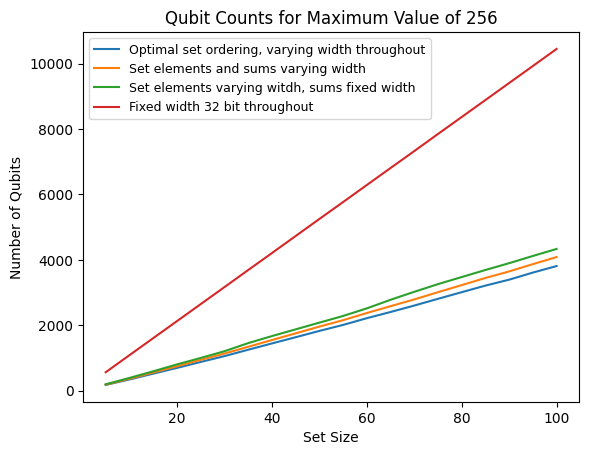

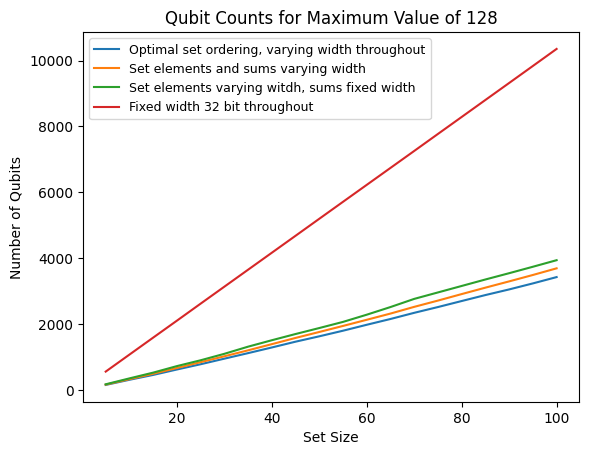

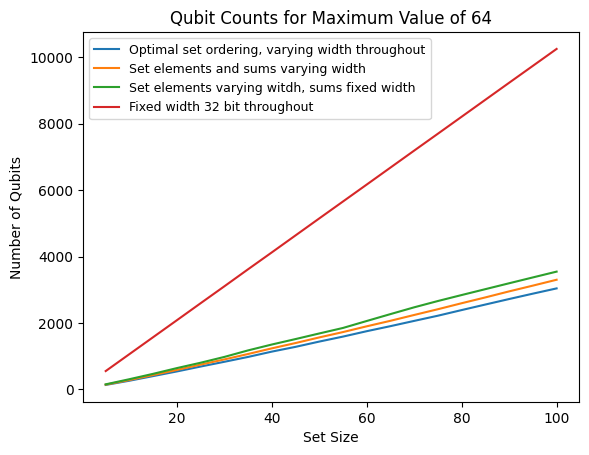

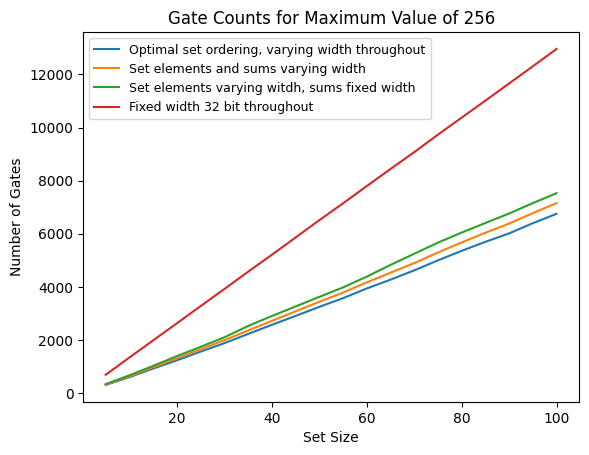

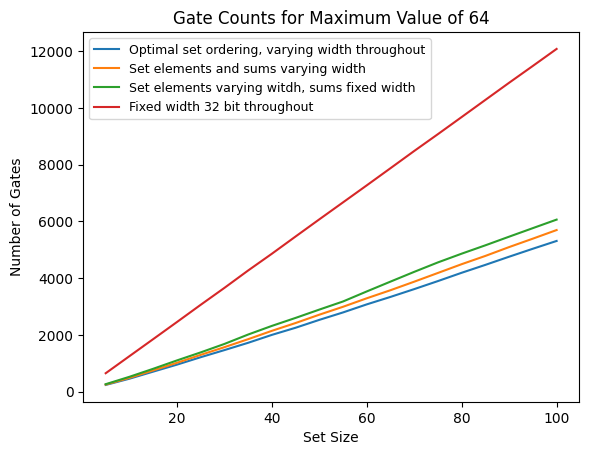

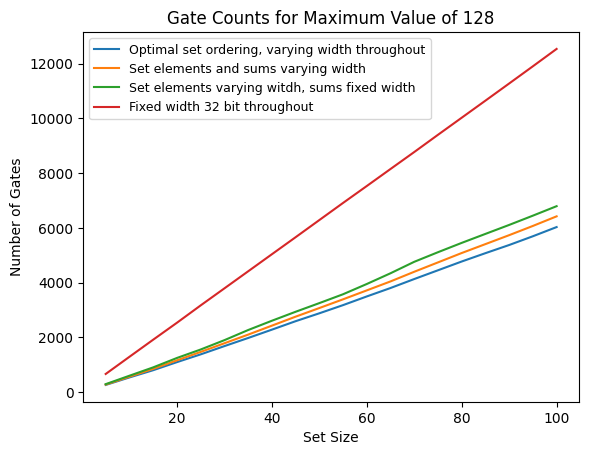

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
import re

# Function to list all relevant CSV files in the directory
qubits = True
def list_csv_files(directory):
    return [f for f in os.listdir(directory) if f.endswith('max.csv')]

# Function to parse filename and extract the values and max number
def parse_filename(filename):
    parts = filename.split('vals')[0], filename.split('max.csv')[0].split('vals')[-1]
    pattern = r'\d+'
    
    # Find all matches of the pattern in the input string
    match = re.findall(pattern, parts[0])
    match = int(match[0])
    return int(match), int(parts[1])  # Return vals, max as integers


# Function to group files by their max value
def group_files_by_max(files):
    groups = {}
    for file in files:
        _, max_val = parse_filename(file)
        if max_val not in groups:
            groups[max_val] = [file]
        else:
            groups[max_val].append(file)
    return groups


# Function to extract the last line of each file, excluding the first column, and create a numpy array
def create_numpy_array_for_group(files, directory):
    data = []
    for file in files:
        vals, _ = parse_filename(file)
        with open(os.path.join(directory, file), 'r') as csvfile:
            for last_line in csvfile:
                pass
            # Exclude the first column ([1:]) from each CSV's last line
            data.append([vals] + list(map(float, last_line.strip().split(',')[1:])))
    data = np.array(data)
    data = data[data[:, 0].argsort()]  # Sort by vals
    return data


# Function to plot the data from numpy arrays, with separate plots for each max group and labeled columns
def plot_data(groups, directory):
    # Define column labels according to the specified mapping
    column_labels = [
        "Optimal set ordering, varying width throughout",
        "Set elements and sums varying width",
        "Set elements varying witdh, sums fixed width",
        "Fixed width 32 bit throughout"
    ]
    
    for max_val, files in groups.items():
        plt.figure()  # Create a new figure for each max group
        plt.rcParams.update({'axes.labelsize': 'medium'})
        data = create_numpy_array_for_group(files, directory)
        for i in range(1, data.shape[1]):  # Skip the first column as it's vals
            # Use the column index (i-1) to get the appropriate label from column_labels list
            lbl = column_labels[i-1] if i-1 < len(column_labels) else f'Column {i}'
            plt.plot(data[:, 0], data[:, i])
        plt.xlabel('Set Size')
        if qubits:
            plt.ylabel('Number of Qubits')
            plt.title(f'Qubit Counts for Maximum Value of {max_val}')
        else:
            plt.ylabel('Number of Gates')
            plt.title(f'Gate Counts for Maximum Value of {max_val}') 
        plt.legend(column_labels, fontsize = 9)
        plt.show()


# Main function to orchestrate the operations
def main(directory):
    files = list_csv_files(directory)
    grouped_files = group_files_by_max(files)

    plot_data(grouped_files, directory)
# Note: Uncomment the line below and specify the directory path to run the script
qubits = True
main('tests/qubitTests')
qubits = False
main('tests/gateTests')